In [48]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import cv2
import pydicom
import yaml  
import ultralytics
from ultralytics import YOLO
print(ultralytics.__version__)
import torch


8.3.115


In [ ]:
#IGNORE THIS (made it work for the dicom issue i was having)
#!pip install --force-reinstall numpy scikit-learn --no-cache-dir
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [ ]:
#IGNORE THIS
!pip uninstall numpy -y
!pip install numpy==1.24
!pip install --upgrade scikit-learn


In [ ]:
#IGNORE THISS
#pip install --upgrade matplotlib

#To fix issue with dicom to jpeg
#!apt-get install libgdcm2.8
#!pip install gdcm pylibjpeg pylibjpeg-libjpeg

#IF YOU NEED TO GET ULTRALYTICS FOR THE FIRST TIME (otherwise, ignore)
!pip install ultralytics
from ultralytics import YOLO

# Visualize Data (IGNORE THIS)

In [ ]:
#IGNORE THIS!!

# Paths
base_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
ex_path2 = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.11827.nii'
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.11827/63.dcm"


# Load DICOM image
dcm_example = pydicom.dcmread(ex_path)
dicom_img = dcm_example.pixel_array
print("DICOM image shape:", dicom_img.shape)

# Load segmentation data
nii_example = nib.load(ex_path2)
seg = nii_example.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)  # Reorient as needed
print("Segmentation shape:", seg.shape)

# Display a slice from the segmentation data and DICOM image
slice_num = 63
seg_slice = seg[slice_num, :, :]
plt.imshow(seg_slice, cmap='gray')
plt.title("Segmentation Slice")
plt.axis('off')
plt.show()

plt.imshow(dicom_img, cmap='gray')
plt.title("Dicom Slice")
plt.axis('off')
plt.show()

# Function to plot fracture with bounding box and show seg values inside the box
def plot_fracture(slice_num, bbox_id):
    # Read bounding boxes file
    train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
    
    # Load the DICOM file
    file_path = f"{base_path}/train_images/{bbox_id}/{slice_num}.dcm"
    file = pydicom.dcmread(file_path)
    img = file.pixel_array
    img = apply_voi_lut(img, file)  # Apply VOI LUT
    
    # Find bounding box data
    info = train_bbox[(train_bbox['StudyInstanceUID'] == bbox_id) & (train_bbox['slice_number'] == slice_num)]
    if not info.empty:
        # Extract bounding box parameters
        x, y, width, height = float(info.x), float(info.y), float(info.width), float(info.height)
        
        # Create rectangle to overlay on DICOM image
        rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')

        # Plot the DICOM image and overlay bounding box
        fig, axes = plt.subplots(figsize=(10, 10))
        axes.imshow(img, cmap="bone")
        axes.add_patch(rect)
        axes.set_title(f"ID:{bbox_id}, Slice: {slice_num}")
        axes.axis('off')

        # Extract the region from the segmentation array inside the bounding box
        # Ensure that the bounding box does not go out of the bounds of the image
        seg_roi = seg[slice_num, int(y):int(y + height), int(x):int(x + width)]
        
        # Display unique values inside the bounding box in the seg array
        print(f"Unique values inside the bounding box (seg slice {slice_num}): {np.unique(seg_roi)}")
        print(f"Segmentation values inside the box:\n{seg_roi}")

        plt.show()
    else:
        print(f"No bounding box found for StudyInstanceUID {bbox_id} and slice {slice_num}")

# Call function for example slice and StudyInstanceUID
plot_fracture(slice_num, '1.2.826.0.1.3680043.11827')

# Create new CSV file

In [10]:
import os
import random
import pandas as pd

# Define base paths
base_path = '/data/kaggledata'
train_images_path = f"{base_path}/train_images"
train_bbox_path = f"{base_path}/train_bounding_boxes.csv"
train_csv_path = f"{base_path}/train.csv"

# Load CSV files
train_bbox = pd.read_csv(train_bbox_path)
train_df = pd.read_csv(train_csv_path)

# Get study IDs that exist in the train_images/ folder
existing_study_ids = set(os.listdir(train_images_path))

# Filter for only valid studies
bbox_filtered = train_bbox[train_bbox['StudyInstanceUID'].isin(existing_study_ids)]
train_df_filtered = train_df[train_df['StudyInstanceUID'].isin(existing_study_ids)]

# Merge bounding boxes with labels
merged = pd.merge(bbox_filtered, train_df_filtered, on='StudyInstanceUID', how='inner')

# Filter only positive cases (patient_overall != 0)
positive_df = merged[merged['patient_overall'] != 0][[
    'StudyInstanceUID', 'slice_number', 'x', 'y', 'width', 'height', 'patient_overall'
]]
num_positive_rows = len(positive_df)
positive_study_ids = set(positive_df['StudyInstanceUID'].unique())

# Filter train_df to get eligible negative studies
negative_candidates = train_df_filtered[
    (train_df_filtered['patient_overall'] == 0) &
    (~train_df_filtered['StudyInstanceUID'].isin(positive_study_ids))
]['StudyInstanceUID'].unique().tolist()

# Shuffle for random sampling
random.shuffle(negative_candidates)

# Accumulate negative rows until they match the positive slice count
neg_rows = []
neg_row_count = 0

for study_id in negative_candidates:
    study_folder = os.path.join(train_images_path, study_id)
    if not os.path.isdir(study_folder):
        continue

    dcm_files = [f for f in os.listdir(study_folder) if f.endswith('.dcm')]
    for filename in sorted(dcm_files, key=lambda x: int(x.replace('.dcm', ''))):
        slice_number = int(filename.replace('.dcm', ''))
        neg_rows.append({
            'StudyInstanceUID': study_id,
            'slice_number': slice_number,
            'x': '',
            'y': '',
            'width': '',
            'height': '',
            'patient_overall': 0
        })
        neg_row_count += 1

        if neg_row_count >= num_positive_rows:
            break
    if neg_row_count >= num_positive_rows:
        break

# Create DataFrame from negatives
negative_df = pd.DataFrame(neg_rows)

# Combine and save
balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
output_path = f"{base_path}/train_bbox_balanced_slices.csv"
balanced_df.to_csv(output_path, index=False)

# Final confirmation
print(f"✅ Positive slice rows: {len(positive_df)}")
print(f"✅ Negative slice rows: {len(negative_df)}")
print(f"✅ Combined balanced CSV saved to: {output_path}")


✅ Positive slice rows: 7217
✅ Negative slice rows: 7217
✅ Combined balanced CSV saved to: /data/kaggledata/train_bbox_balanced_slices.csv


# Prepare file paths for YOLO

In [147]:
import os
import shutil

# Define the directories to remove
yolo_train_images_path = '/data/kaggledata/working/yolo_dataset2/images/train'
yolo_val_images_path = '/data/kaggledata/working/yolo_dataset2/images/val'
yolo_train_labels_path = '/data/kaggledata/working/yolo_dataset2/labels/train'
yolo_val_labels_path = '/data/kaggledata/working/yolo_dataset2/labels/val'
yolo_dataset_path = '/data/kaggledata/working/yolo_dataset2'

# List of directories to remove
directories_to_remove = [
    yolo_train_images_path,
    yolo_val_images_path,
    yolo_train_labels_path,
    yolo_val_labels_path,
    yolo_dataset_path
]

# Remove the directories
for dir_path in directories_to_remove:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f"✅ Removed directory: {dir_path}")
    else:
        print(f"⚠️ Directory not found: {dir_path}")


✅ Removed directory: /data/kaggledata/working/yolo_dataset2/images/train
✅ Removed directory: /data/kaggledata/working/yolo_dataset2/images/val
✅ Removed directory: /data/kaggledata/working/yolo_dataset2/labels/train
✅ Removed directory: /data/kaggledata/working/yolo_dataset2/labels/val
✅ Removed directory: /data/kaggledata/working/yolo_dataset2


In [82]:
#Clear all runs



shutil.rmtree("/home/vonaesch/runs")

# Make File Paths

In [148]:

predicted_masks_dir = '/data/kaggledata/working/predicted_masks'
given_masks_dir = '/data/kaggledata/working/binary_masks_jpg'
kaggle_output_path = "/data/kaggledata/working"

# Set paths
base_path = '/data/kaggledata'
train_images_path = f"{base_path}/train_images"
train_merged_csv_path = f"{base_path}/train_bbox_balanced_slices.csv"
binary_masks_nii_path = '/data/kaggledata/working/binary_masks/' #then its a studyid .nii

yolo_dataset_path = f"{kaggle_output_path}/yolo_dataset2"

yolo_images_path = f"{yolo_dataset_path}/images"
yolo_train_images_path = f"{yolo_images_path}/train"
yolo_val_images_path = f"{yolo_images_path}/val"

yolo_labels_path = f"{yolo_dataset_path}/labels"
yolo_train_labels_path = f"{yolo_labels_path}/train"
yolo_val_labels_path = f"{yolo_labels_path}/val"



## Create Directories


In [149]:
os.makedirs(yolo_train_images_path, exist_ok=True)
os.makedirs(yolo_val_images_path, exist_ok=True)
os.makedirs(yolo_train_labels_path, exist_ok=True)
os.makedirs(yolo_val_labels_path, exist_ok=True)

# Get List of all studies that have binary masks

In [50]:
import os

def get_nii_file_names(dir):
    nii_files = []
    for filename in os.listdir(dir):
        if filename.endswith('.nii'):
            name = os.path.splitext(filename)[0]  # remove .nii
            nii_files.append(name)
    return nii_files

nii_list = get_nii_file_names(binary_masks_nii_path)

print(nii_list)
print(len(nii_list))


['1.2.826.0.1.3680043.20928', '1.2.826.0.1.3680043.1573', '1.2.826.0.1.3680043.10633', '1.2.826.0.1.3680043.26110', '1.2.826.0.1.3680043.18968', '1.2.826.0.1.3680043.19388', '1.2.826.0.1.3680043.26979', '1.2.826.0.1.3680043.30640', '1.2.826.0.1.3680043.11988', '1.2.826.0.1.3680043.30487', '1.2.826.0.1.3680043.21651', '1.2.826.0.1.3680043.16092', '1.2.826.0.1.3680043.25704', '1.2.826.0.1.3680043.10921', '1.2.826.0.1.3680043.24140', '1.2.826.0.1.3680043.26442', '1.2.826.0.1.3680043.32280', '1.2.826.0.1.3680043.5002', '1.2.826.0.1.3680043.8330', '1.2.826.0.1.3680043.1363', '1.2.826.0.1.3680043.3168', '1.2.826.0.1.3680043.18480', '1.2.826.0.1.3680043.6125', '1.2.826.0.1.3680043.4769', '1.2.826.0.1.3680043.3992', '1.2.826.0.1.3680043.26068', '1.2.826.0.1.3680043.6078', '1.2.826.0.1.3680043.17960', '1.2.826.0.1.3680043.5671', '1.2.826.0.1.3680043.26492', '1.2.826.0.1.3680043.12281', '1.2.826.0.1.3680043.3376', '1.2.826.0.1.3680043.8574', '1.2.826.0.1.3680043.27016', '1.2.826.0.1.3680043.3243

# Get list of studies that have binary masks and bounding boxes

In [54]:
import csv

def read_studyinstanceuids_from_csv(csv_path):
    # Read StudyInstanceUIDs from a CSV file
    study_instance_uids = []
    with open(csv_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            study_instance_uids.append(row['StudyInstanceUID'])
    return study_instance_uids

def join_study_instance_uids(nii_list, bbox_csv_path):
    # Read StudyInstanceUIDs from the bounding box CSV
    bbox_study_instance_uids = read_studyinstanceuids_from_csv(bbox_csv_path)
    
    # Find common StudyInstanceUIDs between nii_list and bbox_study_instance_uids
    common_uids = set(nii_list) & set(bbox_study_instance_uids)
    
    # Return the common StudyInstanceUIDs
    return list(common_uids)

def get_unmatched_study_instance_uids(nii_list, common_uids):
    # Return the StudyInstanceUIDs in nii_list that are not in common_uids
    unmatched_uids = [uid for uid in nii_list if uid not in common_uids]
    return unmatched_uids


base_path = '/data/kaggledata'
train_bbox_path = f"{base_path}/train_bounding_boxes.csv"


common_study_instance_uids = join_study_instance_uids(nii_list, train_bbox_path)
unmatched_study_instance_uids = get_unmatched_study_instance_uids(nii_list, common_study_instance_uids)

print("Common UIDs:", common_study_instance_uids)
print("Number of common UIDs:", len(common_study_instance_uids))

print("Unmatched UIDs:", unmatched_study_instance_uids)
print("Number of unmatched UIDs:", len(unmatched_study_instance_uids))


Common UIDs: ['1.2.826.0.1.3680043.23904', '1.2.826.0.1.3680043.1573', '1.2.826.0.1.3680043.19388', '1.2.826.0.1.3680043.11827', '1.2.826.0.1.3680043.26979', '1.2.826.0.1.3680043.5671', '1.2.826.0.1.3680043.26498', '1.2.826.0.1.3680043.4769', '1.2.826.0.1.3680043.9926', '1.2.826.0.1.3680043.32436', '1.2.826.0.1.3680043.20928', '1.2.826.0.1.3680043.14267', '1.2.826.0.1.3680043.26492', '1.2.826.0.1.3680043.15206', '1.2.826.0.1.3680043.28665', '1.2.826.0.1.3680043.1480', '1.2.826.0.1.3680043.25833', '1.2.826.0.1.3680043.11988', '1.2.826.0.1.3680043.21651', '1.2.826.0.1.3680043.28327', '1.2.826.0.1.3680043.32071', '1.2.826.0.1.3680043.8330', '1.2.826.0.1.3680043.31077', '1.2.826.0.1.3680043.4202', '1.2.826.0.1.3680043.30524', '1.2.826.0.1.3680043.26990', '1.2.826.0.1.3680043.5783', '1.2.826.0.1.3680043.27016', '1.2.826.0.1.3680043.17481', '1.2.826.0.1.3680043.20120', '1.2.826.0.1.3680043.5002', '1.2.826.0.1.3680043.26898', '1.2.826.0.1.3680043.26110', '1.2.826.0.1.3680043.21321', '1.2.826.

# Functions for nii masks

In [53]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import pydicom

class NiftiDicomDataset(Dataset):
    def __init__(self, patient_ids, image_dir, mask_dir, target_size=(512, 512)):
        self.patient_ids = patient_ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.samples = self._preload_sample_indices()  

    def _preload_sample_indices(self):
        samples = []
        for pid in self.patient_ids:
            mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
            masks = nib.load(mask_path).get_fdata()
            dicom_dir = os.path.join(self.image_dir, pid)
            
            fg_count = 0
            bg_count = 0
            
            for slice_idx in range(masks.shape[0]):
                if np.any(masks[slice_idx] > 0):
                    fg_count += 1
                    samples.append((pid, slice_idx, True))  
                elif fg_count > 3 * bg_count:
                    bg_count += 1
                    samples.append((pid, slice_idx, False))
        
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pid, slice_idx, _ = self.samples[idx]  
        
        # Load DICOM
        dicom_path = os.path.join(self.image_dir, pid, f"{slice_idx+1}.dcm")
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize image
        img = cv2.resize(img, self.target_size)  # [H, W]
        
        # Load mask
        mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
        masks = nib.load(mask_path).get_fdata()
        mask = masks[slice_idx].astype(np.float32)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)  # [H, W]
        
        # Convert to PyTorch tensors
        img_tensor = torch.tensor(img).unsqueeze(0).float()  # [1, H, W]
        mask_tensor = torch.tensor(mask).unsqueeze(0).float()  # [1, H, W]
        
        return img_tensor, mask_tensor



masks = NiftiDicomDataset(
    patient_ids=nii_list,
    image_dir=train_images_path,
    mask_dir=binary_masks_nii_path,
    target_size=(512, 512)
)

# Visualize Some of these masks side by side with dicom

Sample index: 23470
('1.2.826.0.1.3680043.24891', 74, True)
Sample index: 13052
('1.2.826.0.1.3680043.3882', 220, False)
Sample index: 15511
('1.2.826.0.1.3680043.31077', 507, False)
Sample index: 13090
('1.2.826.0.1.3680043.26898', 154, True)
Sample index: 1397
('1.2.826.0.1.3680043.19388', 276, True)


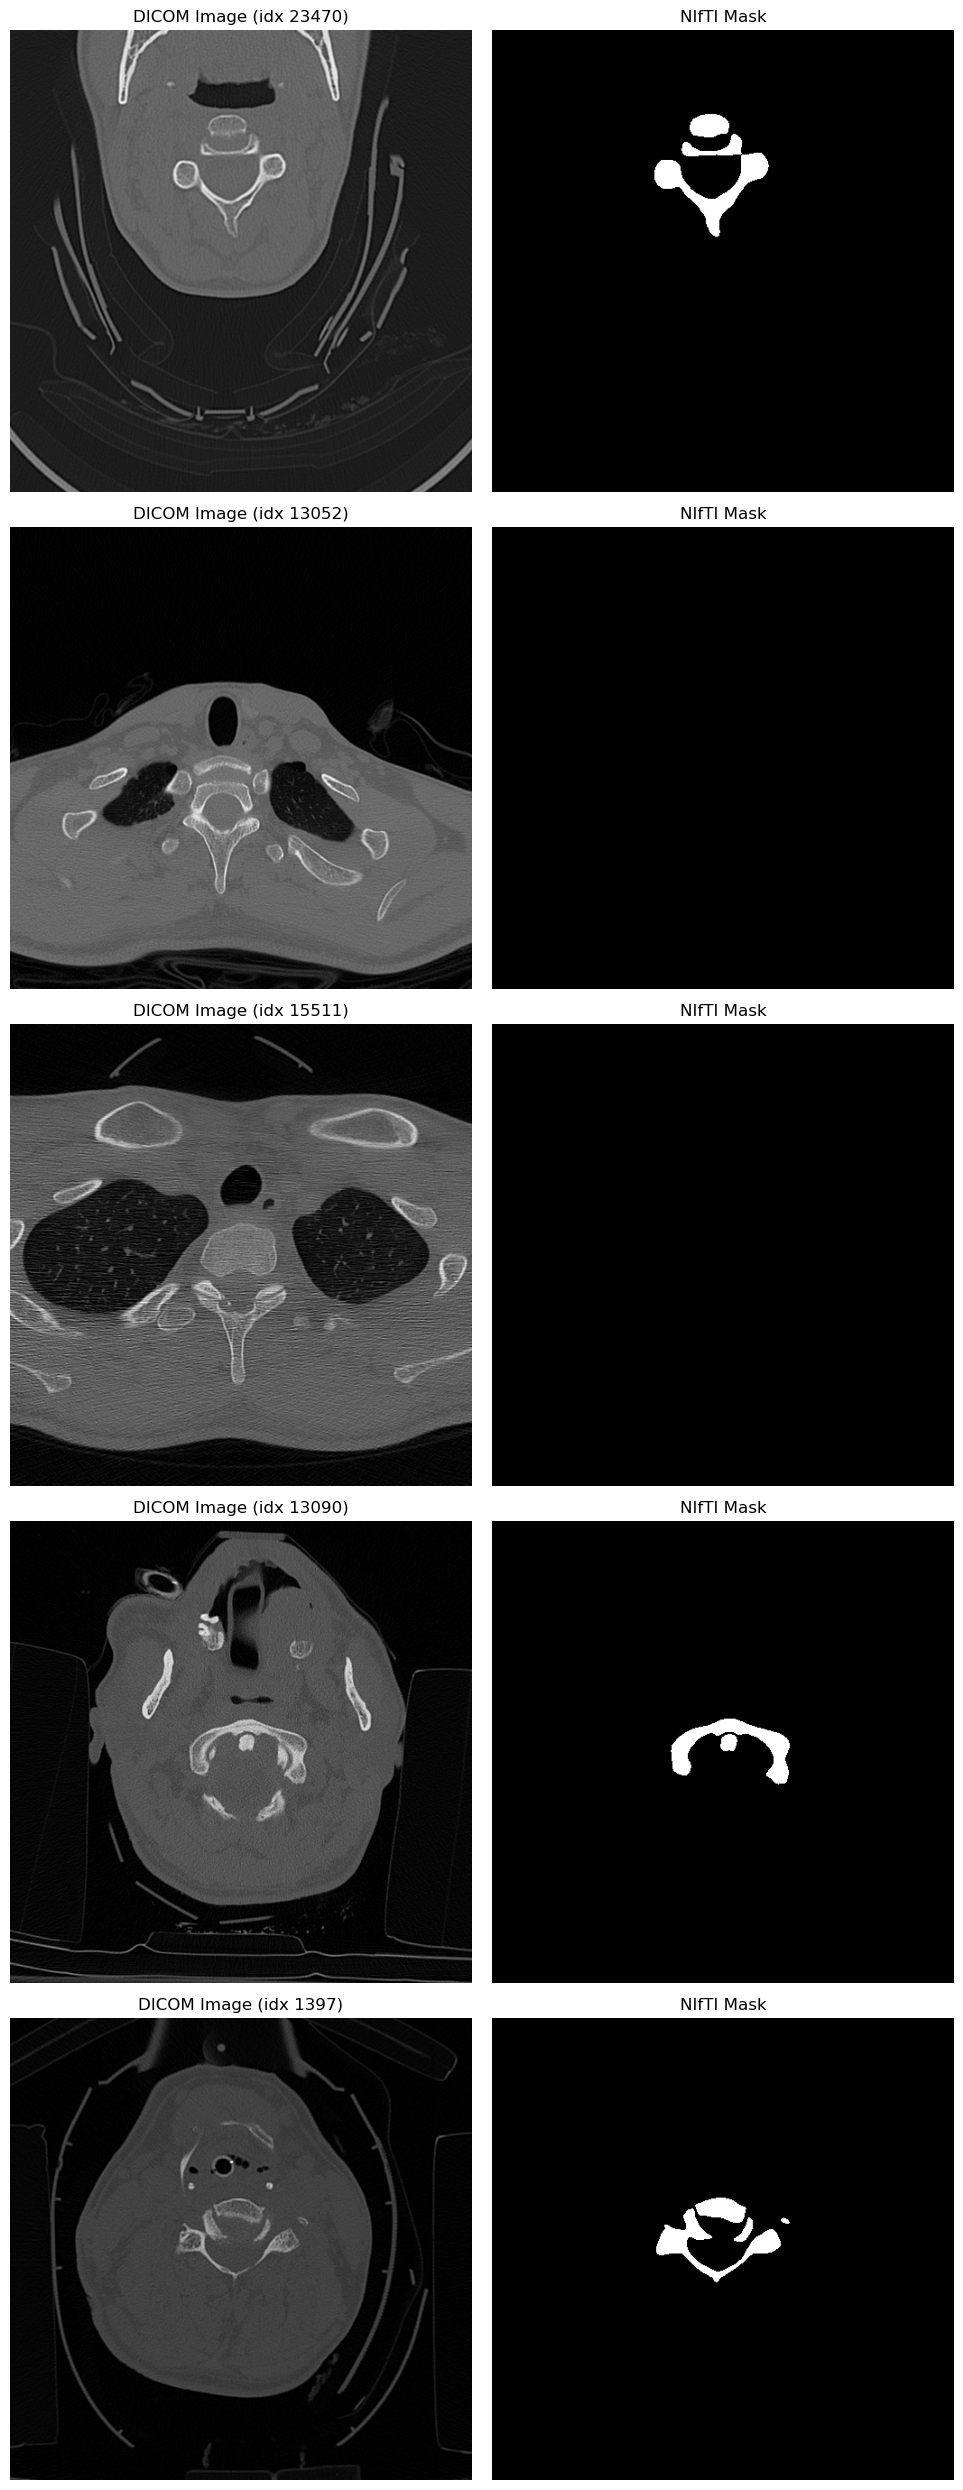

In [55]:
import random
import matplotlib.pyplot as plt

num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    idx = random.randint(0, len(masks) - 1)
    img_tensor, mask_tensor = masks[idx]
    print(f"Sample index: {idx}")
    print(masks.samples[idx])

    img = img_tensor.squeeze().numpy()
    mask = mask_tensor.squeeze().numpy()

    # DICOM image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f'DICOM Image (idx {idx})')
    axes[i, 0].axis('off')

    # NIfTI mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('NIfTI Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Save masks as jpgs


In [ ]:

import os
import torch
from torchvision import transforms
import cv2

os.makedirs(masks_dir, exist_ok=True)


to_pil = transforms.ToPILImage()

# Iterate through the dataset
for idx in range(len(masks)):
    img_tensor, mask_tensor = masks[idx]
    pid, slice_idx, is_foreground = masks.samples[idx]

    # Check if the sample is foreground or background
    if is_foreground:
        # Convert the mask to a numpy array
        mask = mask_tensor.squeeze().numpy()  # [H, W]
        

        mask_pil = to_pil(mask_tensor.squeeze())  # Convert tensor to PIL image for saving
        
        # Define the filename using the studyid and slice number
        filename = f"{pid}_{slice_idx}.jpg"
        file_path = os.path.join(masks_dir, filename)
        
        # Save the image
        mask_pil.save(file_path)
        print(f"Saved: {file_path}")



# Show a couple of thes masks

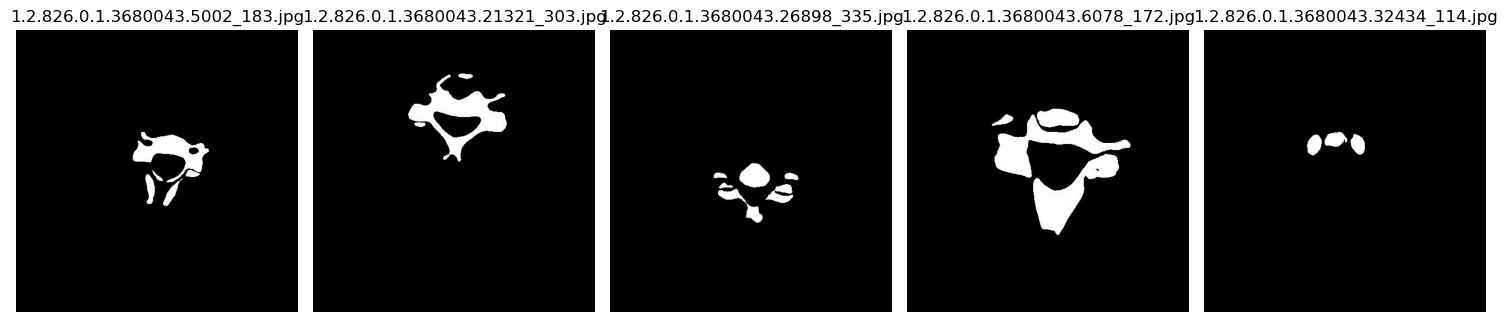

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Parameters
num_samples = 5  # Number of images to display
mask_filenames = os.listdir(masks_dir)
random_filenames = random.sample(mask_filenames, num_samples)  # Random selection

# Load images
images = [Image.open(os.path.join(masks_dir, fname)) for fname in random_filenames]

# Display side by side
plt.figure(figsize=(15, 5))
for i, img in enumerate(images):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(random_filenames[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# THRESHOLD, NORMALIZALE, MASK, CONVERT 

# Create CSV that has segmentation masks + bounding boxes

In [40]:
import os
import random
import pandas as pd

# Define base paths
base_path = '/data/kaggledata'
train_images_path = f"{base_path}/train_images"
train_bbox_path = f"{base_path}/train_bounding_boxes.csv"
train_csv_path = f"{base_path}/train.csv"

# Load CSV files
train_bbox = pd.read_csv(train_bbox_path)
train_df = pd.read_csv(train_csv_path)



# Get study IDs that exist in the train_images/ folder
existing_study_ids = set(os.listdir(train_images_path))

# Filter for only valid studies
bbox_filtered = train_bbox[train_bbox['StudyInstanceUID'].isin(existing_study_ids)]
train_df_filtered = train_df[train_df['StudyInstanceUID'].isin(existing_study_ids)]

# Merge bounding boxes with labels, considering common studies
merged = pd.merge(bbox_filtered, train_df_filtered, on='StudyInstanceUID', how='inner')
merged_common = merged[merged['StudyInstanceUID'].isin(common_study_instance_uids)]

#common_study_instance_uids are all the studies that have bounding boxes, and segmenetation masks

#I used the same pipeline as before to make sure i get all the boundingb ox coordinates, etc..
#then only used the ones where they have masks


# Filter only positive cases (patient_overall != 0) from the common studies
positive_df = merged_common[merged_common['patient_overall'] != 0][[
    'StudyInstanceUID', 'slice_number', 'x', 'y', 'width', 'height', 'patient_overall'
]]
num_positive_rows = len(positive_df)
positive_study_ids = set(positive_df['StudyInstanceUID'].unique())

# Now filter train_df for negative studies based on nii_list and excluding common studies
negative_candidates = [study_id for study_id in nii_list if study_id not in common_study_instance_uids]


#Making sure that all slices with bounding boxes are used
#Then using the rest of the slices with masks as negative for training

# Shuffle for random sampling
random.shuffle(negative_candidates)

# Accumulate negative rows until they match the positive slice count
neg_rows = []
neg_row_count = 0

for study_id in negative_candidates:
    study_folder = os.path.join(train_images_path, study_id)
    if not os.path.isdir(study_folder):
        continue

    dcm_files = [f for f in os.listdir(study_folder) if f.endswith('.dcm')]
    for filename in sorted(dcm_files, key=lambda x: int(x.replace('.dcm', ''))):
        slice_number = int(filename.replace('.dcm', ''))
        neg_rows.append({
            'StudyInstanceUID': study_id,
            'slice_number': slice_number,
            'x': '',
            'y': '',
            'width': '',
            'height': '',
            'patient_overall': 0
        })
        neg_row_count += 1

        if neg_row_count >= num_positive_rows:
            break
    if neg_row_count >= num_positive_rows:
        break

# Create DataFrame from negatives
negative_df = pd.DataFrame(neg_rows)

# Combine and save
balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
output_path = f"{base_path}/masks_balanced.csv"
balanced_df.to_csv(output_path, index=False)

# Final confirmation
print(f"✅ Positive slice rows: {len(positive_df)}")
print(f"✅ Negative slice rows: {len(negative_df)}")
print(f"✅ Combined balanced CSV saved to: {output_path}")


✅ Positive slice rows: 1494
✅ Negative slice rows: 1494
✅ Combined balanced CSV saved to: /data/kaggledata/masks_balanced.csv


# Final process w/ masks

In [ ]:
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from sklearn.model_selection import train_test_split
import albumentations as A

# === Threshold pixels in HU range ===
def threshold_hu(pixels, lower, upper):
    pixels = pixels.astype(np.float32)
    pixels = np.where(pixels < lower, lower, pixels)
    pixels = np.where(pixels > upper, upper, pixels)
    return pixels

# === Windowing and normalize to uint8 ===
def window_and_normalize(pixel_array, window_center=500, window_width=2000):
    lower = window_center - window_width // 2
    upper = window_center + window_width // 2
    pixels = np.clip(pixel_array, lower, upper)
    pixels = (pixels - lower) / (upper - lower)
    pixels = (pixels * 255).astype(np.uint8)
    return pixels

# === Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) ===
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Load the CSV
df = pd.read_csv('/data/kaggledata/train_bbox_balanced_slices.csv')

# Get unique StudyInstanceUIDs
unique_studies = df['StudyInstanceUID'].unique()

# Split the unique studies into train and validation sets
train_studies, val_studies = train_test_split(unique_studies, test_size=0.2, random_state=42)

# Filter the dataframe
train_df = df[df['StudyInstanceUID'].isin(train_studies)].reset_index(drop=True)
val_df = df[df['StudyInstanceUID'].isin(val_studies)].reset_index(drop=True)

assert set(train_df['StudyInstanceUID']).isdisjoint(val_df['StudyInstanceUID']), "Overlap detected!"

# === Helper: save image and label in YOLO format ===
def process_and_save(row, img_dir, label_dir):
    study_uid = row['StudyInstanceUID']
    slice_number = int(row['slice_number'])
    x, y, w, h = row['x'], row['y'], row['width'], row['height']
    class_id = int(row['patient_overall'])

    dicom_path = f"{train_images_path}/{study_uid}/{slice_number}.dcm"
    image_name = f"{study_uid}_{slice_number}.jpg"
    label_name = f"{study_uid}_{slice_number}.txt"
    
    output_img_path = os.path.join(img_dir, image_name)
    output_label_path = os.path.join(label_dir, label_name)

    try:
        dicom = pydicom.dcmread(dicom_path)
        pixels = dicom.pixel_array.astype(np.int16)

        # Convert to HU
        slope = float(dicom.RescaleSlope) if 'RescaleSlope' in dicom else 1.0
        intercept = float(dicom.RescaleIntercept) if 'RescaleIntercept' in dicom else 0.0
        pixels = pixels * slope + intercept
        
        height, width = pixels.shape

        # Preprocessing
        thresholded = threshold_hu(pixels, lower=290, upper=1700)
        normalized = window_and_normalize(thresholded, window_center=500, window_width=2000)
        enhanced = apply_clahe(normalized)

        # === Locate the mask file ===
        mask_file = os.path.join(predicted_masks_dir, study_uid, f"{slice_number}.jpeg")
        #print(f"Checking predicted mask: {mask_file}")

        if not os.path.exists(mask_file):
            alt_mask_file = os.path.join(given_masks_dir, f"{study_uid}_{slice_number}.jpg")
            if os.path.exists(alt_mask_file):
                mask_file = alt_mask_file
            else:
                # If no mask exists, just save the DICOM image as JPEG
                print(f"[Missing mask] Saving the DICOM image as JPEG: {dicom_path}")
                cv2.imwrite(output_img_path, enhanced)  # Save the processed DICOM image
                if class_id == 0:
                    open(output_label_path, 'w').close()
                else:
                    x_center = (x + w / 2) / width
                    y_center = (y + h / 2) / height
                    w_norm = w / width
                    h_norm = h / height
                    with open(output_label_path, "w") as f:
                        f.write(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
                return  # Exit early, as we saved the DICOM as JPEG

        # === Load and process mask ===
        mask = cv2.imread(mask_file, 0)
        if mask is None:
            print(f"Failed to load mask image: {mask_file}")
            return
        else:
            mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

            if np.sum(binary_mask) == 0:
                return

        masked_image = cv2.bitwise_and(enhanced, enhanced, mask=binary_mask)
        cv2.imwrite(output_img_path, masked_image)

        if class_id == 0:
            open(output_label_path, 'w').close()
        else:
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height

            with open(output_label_path, "w") as f:
                f.write(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    except Exception as e:
        print(f"Failed to process {dicom_path}: {e}")

# Process training set
for _, row in train_df.iterrows():
    process_and_save(row, yolo_train_images_path, yolo_train_labels_path)

# Process validation set
for _, row in val_df.iterrows():
    process_and_save(row, yolo_val_images_path, yolo_val_labels_path)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


# view some

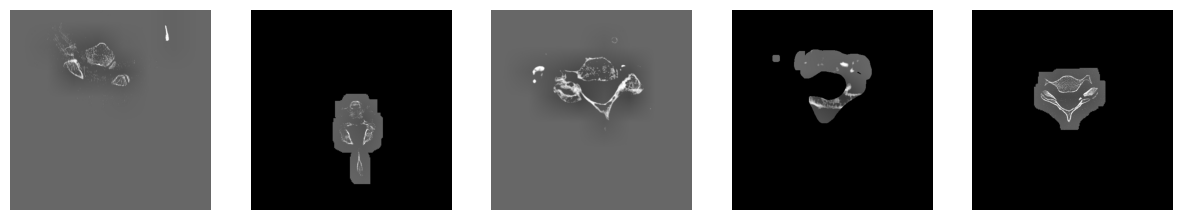

In [182]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Define the path where your YOLO training images are stored
yolo_train_images_path = '/data/kaggledata/working/yolo_dataset2/images/train'

# List all the images in the directory
image_files = [f for f in os.listdir(yolo_train_images_path) if f.endswith('.jpg')]

# Select exactly 5 random images to display
sample_images = random.sample(image_files, 5)

# Shuffle the order of the selected images to randomize the display
random.shuffle(sample_images)

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, img_file in zip(axes, sample_images):
    # Load the image
    img_path = os.path.join(yolo_train_images_path, img_file)
    img = cv2.imread(img_path)

    # Convert the image from BGR (OpenCV format) to RGB for Matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    ax.imshow(img_rgb)
    ax.axis('off')  # Hide axes
    

plt.show()



# Copy of Original Approach

In [ ]:
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from sklearn.model_selection import train_test_split

# === Threshold pixels in HU range ===
def threshold_hu(pixels, lower, upper):
    pixels = pixels.astype(np.float32)
    pixels = np.where(pixels < lower, 0, pixels)
    pixels = np.where(pixels > upper, upper, pixels)
    return pixels


# === Normalize to uint8 (full dynamic range) ===
def normalize_to_uint8(pixel_array):
    pixels = pixel_array.astype(np.float32)
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    if max_val - min_val > 0:
        pixels = (pixels - min_val) / (max_val - min_val)
    pixels *= 255.0
    return pixels.astype(np.uint8)

# Load the CSV
df = pd.read_csv(train_merged_csv_path)

# Get unique StudyInstanceUIDs
unique_studies = df['StudyInstanceUID'].unique()

# Split the unique studies into train and validation sets
train_studies, val_studies = train_test_split(unique_studies, test_size=0.2, random_state=42)

# Now filter the dataframe based on the split studies
train_df = df[df['StudyInstanceUID'].isin(train_studies)].reset_index(drop=True)
val_df = df[df['StudyInstanceUID'].isin(val_studies)].reset_index(drop=True)

# (Optional sanity check)
assert set(train_df['StudyInstanceUID']).isdisjoint(val_df['StudyInstanceUID']), "Overlap detected between train and val!"

# === Helper: save image and label in YOLO format ===
def process_and_save(row, img_dir, label_dir):
    study_uid = row['StudyInstanceUID']
    slice_number = int(row['slice_number'])
    x, y, w, h = row['x'], row['y'], row['width'], row['height']
    class_id = int(row['patient_overall'])

    dicom_path = f"{train_images_path}/{study_uid}/{slice_number}.dcm"
    image_name = f"{study_uid}_{slice_number}.jpg"
    label_name = f"{study_uid}_{slice_number}.txt"
    output_img_path = os.path.join(img_dir, image_name)
    output_label_path = os.path.join(label_dir, label_name)

    try:
        dicom = pydicom.dcmread(dicom_path)
        pixels = dicom.pixel_array.astype(np.int16)

        # Convert to Hounsfield Units (HU)
        slope = float(dicom.RescaleSlope) if 'RescaleSlope' in dicom else 1.0
        intercept = float(dicom.RescaleIntercept) if 'RescaleIntercept' in dicom else 0.0
        pixels = pixels * slope + intercept
        
        height, width = pixels.shape

        #_, thresholded = cv2.threshold(pixels, 0, 2000, cv2.THRESH_TOZERO)

        thresholded = threshold_hu(pixels, lower=290, upper=1700)

        # Normalize to uint8 for saving as image
        normalized = normalize_to_uint8(thresholded)

        # Save the image
        cv2.imwrite(output_img_path, normalized)

        # Save YOLO label
        if class_id == 0:
            open(output_label_path, 'w').close()
        else:
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height

            with open(output_label_path, "w") as f:
                f.write(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    except Exception as e:
        print(f"Failed to process {dicom_path}: {e}")

# Process training set
for _, row in train_df.iterrows():
    process_and_save(row, yolo_train_images_path, yolo_train_labels_path)

# Process validation set
for _, row in val_df.iterrows():
    process_and_save(row, yolo_val_images_path, yolo_val_labels_path)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


In [132]:
print("Full dataset class distribution:")
print(df['patient_overall'].value_counts(normalize=True))

print("\nTrain set class distribution:")
print(train_df['patient_overall'].value_counts(normalize=True))

print("\nValidation set class distribution:")
print(val_df['patient_overall'].value_counts(normalize=True))


Full dataset class distribution:
patient_overall
1    0.5
0    0.5
Name: proportion, dtype: float64

Train set class distribution:
patient_overall
1    0.513267
0    0.486733
Name: proportion, dtype: float64

Validation set class distribution:
patient_overall
0    0.547954
1    0.452046
Name: proportion, dtype: float64


# View some of Michael's predicted masks 

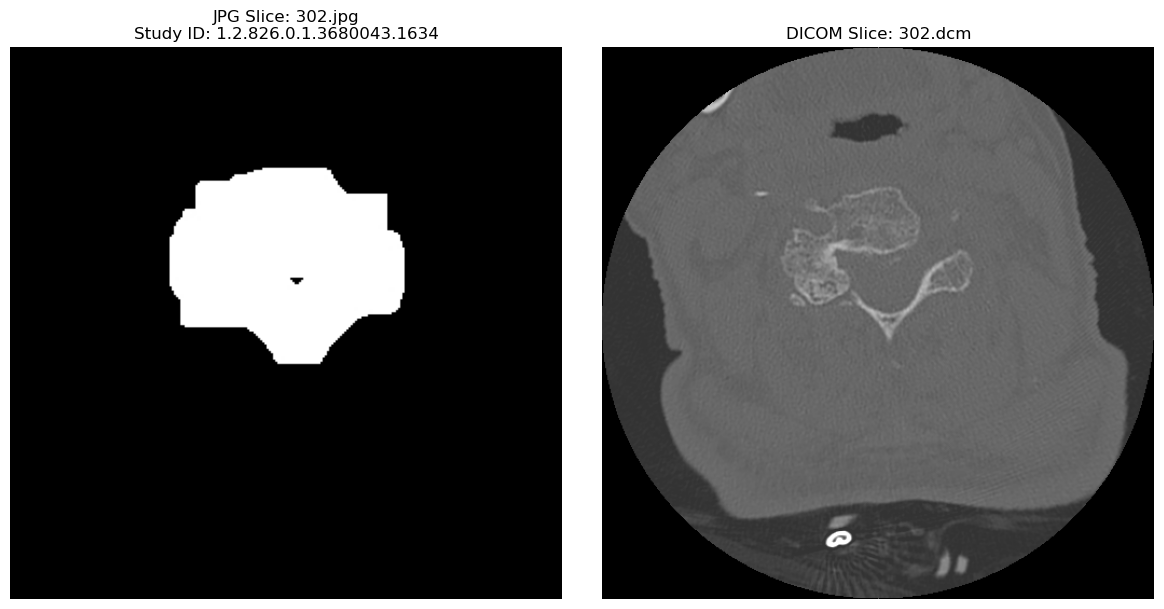

In [101]:
import os
import random
import csv
import matplotlib.pyplot as plt
from PIL import Image
import pydicom

# Configurable paths
base_image_dir = '/data/kaggledata/working/predicted_masks'
dicom_base_path = '/data/kaggledata/train_images'
csv_path = '/data/kaggledata/train_bounding_boxes.csv'

# Read study IDs from CSV (assumes column name is 'StudyInstanceUID')
def read_study_ids_from_csv(path):
    study_ids = []
    with open(path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            study_ids.append(row['StudyInstanceUID'])
    return study_ids

# Load study IDs from CSV
csv_study_ids = read_study_ids_from_csv(csv_path)

# Filter to only those that have folders in base_image_dir
valid_study_ids = [sid for sid in csv_study_ids if os.path.isdir(os.path.join(base_image_dir, sid))]

# Keep trying until a study with at least one valid slice is found
while True:
    random_study_id = random.choice(valid_study_ids)
    study_folder = os.path.join(base_image_dir, random_study_id)

    # List valid jpg slices
    jpg_files = [f for f in os.listdir(study_folder) if f.endswith('.jpeg') and f[:-5].isdigit()]
    if not jpg_files:
        continue  # Try another study

    # Choose a random valid slice
    random_jpg = random.choice(jpg_files)
    slice_num = os.path.splitext(random_jpg)[0]

    jpg_path = os.path.join(study_folder, random_jpg)
    dcm_path = os.path.join(dicom_base_path, random_study_id, f"{slice_num}.dcm")

    # Check if the DICOM file exists too
    if not os.path.exists(dcm_path):
        continue  # Try another slice or study

    break  # Valid study and slice found

# Load images
jpg_image = Image.open(jpg_path)
dicom_image = pydicom.dcmread(dcm_path).pixel_array

# Display images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(jpg_image, cmap='gray')
plt.title(f'JPG Slice: {slice_num}.jpg\nStudy ID: {random_study_id}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dicom_image, cmap='gray')
plt.title(f'DICOM Slice: {slice_num}.dcm')
plt.axis('off')

plt.tight_layout()
plt.show()


# TESTING ONE IMAGE FOR DICOM THRESHOLD

In [ ]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Paths ===
dicom_path = "/data/kaggledata/train_images/1.2.826.0.1.3680043.21296/244.dcm"

def threshold_image(pixels, lower, upper):
    # Clip pixel values to be within [lower, upper]
    pixels = np.clip(pixels, lower, upper)
    return pixels

# === Normalize to uint8 ===
def normalize_to_uint8(pixels):
    pixels = pixels.astype(np.float32)
    max_val = np.max(pixels)
    if max_val > 0:
        pixels /= max_val
    pixels *= 255.0
    return pixels.astype(np.uint8)

# === Load and process DICOM ===
dicom = pydicom.dcmread(dicom_path)
dicom_pixels = dicom.pixel_array

#what is the defualt range that its trying to visualize?

# Threshold and mask
thresholded = threshold_image(dicom_pixels, 300, 2000)

# Normalize
normalized = normalize_to_uint8(thresholded)


# === Display Original and Colorized ===
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(dicom_pixels)
plt.title("Original DICOM Slice")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized)
plt.title("Converted")
plt.axis('off')

plt.tight_layout()
plt.show()


# Create YOLO YAML File

In [134]:
import yaml

# YAML output path
yaml_file_path = f"{kaggle_output_path}/yolo_dataset_config.yaml"

# Create YAML dictionary with full paths
yolo_config = {
    'path': yolo_dataset_path,               # full dataset path
    'train': yolo_train_images_path,         # full path to train images
    'val': yolo_val_images_path,             # full path to val images
    'names': ['Broken'],                    # class names should be a list
    'nc': 1                                # number of classes
}

# Write YAML to file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(yolo_config, yaml_file, default_flow_style=False)

print(f"YOLOv8 config YAML saved to: {yaml_file_path}")


YOLOv8 config YAML saved to: /data/kaggledata/working/yolo_dataset_config.yaml


# Make dataset with masks

In [104]:
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from sklearn.model_selection import train_test_split

# === Threshold pixels in HU range ===
def threshold_hu(pixels, lower, upper):
    pixels = pixels.astype(np.float32)
    pixels = np.where(pixels < lower, 0, pixels)
    pixels = np.where(pixels > upper, upper, pixels)
    return pixels


# === Normalize to uint8 (full dynamic range) ===
def normalize_to_uint8(pixel_array):
    pixels = pixel_array.astype(np.float32)
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    if max_val - min_val > 0:
        pixels = (pixels - min_val) / (max_val - min_val)
    pixels *= 255.0
    return pixels.astype(np.uint8)

# Load the CSV
df = pd.read_csv(train_merged_csv_path)

# Get unique StudyInstanceUIDs
unique_studies = df['StudyInstanceUID'].unique()

# Split the unique studies into train and validation sets
train_studies, val_studies = train_test_split(unique_studies, test_size=0.2, random_state=42)

# Now filter the dataframe based on the split studies
train_df = df[df['StudyInstanceUID'].isin(train_studies)].reset_index(drop=True)
val_df = df[df['StudyInstanceUID'].isin(val_studies)].reset_index(drop=True)

# (Optional sanity check)
assert set(train_df['StudyInstanceUID']).isdisjoint(val_df['StudyInstanceUID']), "Overlap detected between train and val!"

# === Helper: save image and label in YOLO format ===
def process_and_save(row, img_dir, label_dir):
    study_uid = row['StudyInstanceUID']
    slice_number = int(row['slice_number'])
    x, y, w, h = row['x'], row['y'], row['width'], row['height']
    class_id = int(row['patient_overall'])

    dicom_path = f"{train_images_path}/{study_uid}/{slice_number}.dcm"
    image_name = f"{study_uid}_{slice_number}.jpg"
    label_name = f"{study_uid}_{slice_number}.txt"
    output_img_path = os.path.join(img_dir, image_name)
    output_label_path = os.path.join(label_dir, label_name)

    try:
        dicom = pydicom.dcmread(dicom_path)
        pixels = dicom.pixel_array.astype(np.int16)

        # Convert to Hounsfield Units (HU)
        slope = float(dicom.RescaleSlope) if 'RescaleSlope' in dicom else 1.0
        intercept = float(dicom.RescaleIntercept) if 'RescaleIntercept' in dicom else 0.0
        pixels = pixels * slope + intercept
        
        height, width = pixels.shape

        #_, thresholded = cv2.threshold(pixels, 0, 2000, cv2.THRESH_TOZERO)

        thresholded = threshold_hu(pixels, lower=290, upper=1700)

        # Normalize to uint8 for saving as image
        normalized = normalize_to_uint8(thresholded)

        # Save the image
        cv2.imwrite(output_img_path, normalized)

        # Save YOLO label
        if class_id == 0:
            open(output_label_path, 'w').close()
        else:
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height

            with open(output_label_path, "w") as f:
                f.write(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    except Exception as e:
        print(f"Failed to process {dicom_path}: {e}")

# Process training set
for _, row in train_df.iterrows():
    process_and_save(row, yolo_train_images_path, yolo_train_labels_path)

# Process validation set
for _, row in val_df.iterrows():
    process_and_save(row, yolo_val_images_path, yolo_val_labels_path)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


✅ Positive slice rows: 7217
✅ Negative slice rows: 7217
✅ Combined balanced CSV saved to: /data/kaggledata/train_bbox_balanced_slices.csv
📊 Training samples: 11547
📊 Validation samples: 2887
📁 YOLO training images saved to: /data/kaggledata/working/yolo_dataset2/images/train
📁 YOLO training labels saved to: /data/kaggledata/working/yolo_dataset2/labels/train
📁 YOLO validation images saved to: /data/kaggledata/working/yolo_dataset2/images/val
📁 YOLO validation labels saved to: /data/kaggledata/working/yolo_dataset2/labels/val


In [181]:
#!CUDA_VISIBLE_DEVICES=1 env yolo train model=yolov8m.pt data=/data/kaggledata/working/yolo_dataset_config.yaml epochs=100 patience=10 imgsz=640 batch=32 freeze=8 conf=0.2 iou=0.4
!yolo train model=yolov8s.pt data=/data/kaggledata/working/yolo_dataset_config.yaml epochs=50 patience=20 imgsz=640 batch=32 freeze=7 lr0=0.02 lrf=0.02 optimizer="adam"


/bin/bash: /home/vonaesch/miniconda3/envs/cv-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
New https://pypi.org/project/ultralytics/8.3.133 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.115 🚀 Python-3.10.13 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/data/kaggledata/working/yolo_dataset_config.yaml, epochs=50, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=7, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride

In [184]:
!yolo val model=/home/vonaesch/runs/detect/train15/weights/best.pt \
         data=/data/kaggledata/working/yolo_dataset_config.yaml \
         imgsz=640 \
         conf=0.2 \
         save_txt=True



#!yolo predict model=/kaggle/working/runs/detect/train/weights/best.pt \
            #data=/kaggle/working/yolo_dataset_config.yaml \
            #imgsz=640/
            #save=True /
            #source=/kaggle/working/yolo_dataset/images/val 
            #\ conf=0.1


/bin/bash: /home/vonaesch/miniconda3/envs/cv-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Ultralytics 8.3.115 🚀 Python-3.10.13 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1078.4±175.7 MB/s, size: 17.9 KB)
val: Scanning /data/kaggledata/working/yolo_dataset2/labels/val.cache... 3121 im
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       3121       1407      0.458      0.158      0.287      0.116
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val6
💡 Learn more at https://docs.ultralytics.com/modes/val



Custom Confusion Matrix:
                Actual: Broken   Actual: Background
Pred: Broken     417              0
Pred: Background 990              1714


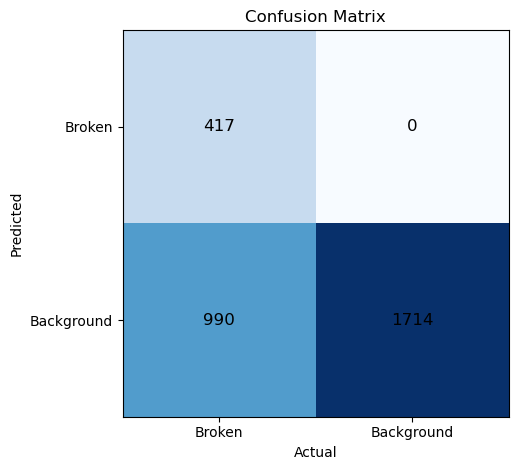

In [185]:
import os
import numpy as np
import matplotlib.pyplot as plt

gt_label_dir = yolo_val_labels_path
pred_label_dir = '/home/vonaesch/runs/detect/val6/labels'

background_images = 0
background_with_fp = 0
background_true_neg = 0
broken_tp = 0
broken_fn = 0

for label_file in os.listdir(gt_label_dir):
    if not label_file.endswith('.txt'):
        continue

    gt_path = os.path.join(gt_label_dir, label_file)
    pred_path = os.path.join(pred_label_dir, label_file)

    # Read and clean ground truth lines
    with open(gt_path, 'r') as f:
        gt_lines = [line.strip() for line in f.readlines() if line.strip() != '']
    is_background = (len(gt_lines) == 0)

    # Read and clean prediction lines
    if os.path.exists(pred_path):
        with open(pred_path, 'r') as f:
            pred_lines = [line.strip() for line in f.readlines() if line.strip() != '']
        has_prediction = (len(pred_lines) > 0)
    else:
        has_prediction = False

    # Update counters for confusion matrix
    if is_background:
        if has_prediction:
            background_with_fp += 1  # False Positive: predicted as broken, actually background
        else:
            background_true_neg += 1  # True Negative: predicted as background, actually background
    else:
        if has_prediction:
            broken_tp += 1  # True Positive: predicted as broken, actually broken
        else:
            broken_fn += 1  # False Negative: predicted as background, actually broken

# Build confusion matrix: rows = predicted, cols = actual
# Rows: Predicted → Broken, Background
# Columns: Actual → Broken, Background
matrix = np.array([[broken_tp, background_with_fp],      # Predicted Broken
                   [broken_fn, background_true_neg]])    # Predicted Background

print("\nCustom Confusion Matrix:")
print("                Actual: Broken   Actual: Background")
print(f"Pred: Broken     {broken_tp:<16} {background_with_fp}")
print(f"Pred: Background {broken_fn:<16} {background_true_neg}")

# Plot confusion matrix as heatmap (predicted on y-axis, actual on x-axis)
fig, ax = plt.subplots()
im = ax.imshow(matrix, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['Broken', 'Background'])    # X → Actual
ax.set_yticklabels(['Broken', 'Background'])    # Y → Predicted

# Show values in cells
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Confusion Matrix')

# Save and show image
plt.tight_layout()
plt.savefig('custom_confusion_matrix.png')
plt.show()
